In [73]:
##################### Import Libraries ############################
import pybamm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
#################### Initiate Blank Model #########################
model = pybamm.BaseModel()
model.name = "Marinescu_2018"

In [3]:
################### Variables #####################################
S8 = pybamm.Variable("S8")
S4 = pybamm.Variable("S4")
S2 = pybamm.Variable("S2")
S  = pybamm.Variable("S")
Sp = pybamm.Variable("Sp")
Ss = pybamm.Variable("Ss")
V  = pybamm.Variable("V")

In [4]:
# Model Variables
model.variables = {"S8" : S8,
                   "S4" : S4,
                   "S2" : S2,
                   "S" : S,
                   "Sp" : Sp,
                   "Ss" : Ss,
                   "V" : V}

In [113]:
##################### Parameters #################################

# Set Parameters values normally

R = 8.3145
T = 298
F = 9.649*(10**4)
v = 0.0114

EH0 = 2.35
EL0 = 2.18

k_p    = 100
k_s    = 0 #0.0002 for charge
f_s    = 0.25
S_star = 0.0001
rho_s  = 2*(10**3)

Ms = 32
ne  = 4
ns  = 1
ns2 = 2
ns4 = 4
ns8 = 8
n4  = 4

ih0 = 1
il0 = 0.5
ar  = 0.960
m_s = 2.7
I   = 0.01 # we get numerical issues at 0.1

i_h_term_coef   = ns8*Ms*I*v*rho_s/(ne*F*k_p*(m_s**2))

i_coef   = ne*F/(2*R*T)
i_h_coef = -2*ih0*ar
i_l_coef = -2*il0*ar

E_H_coef = R*T/(4*F)
f_h      = (ns4**2)*Ms*v/ns8
f_l      = (ns**2)*ns2*Ms**2*(v**2)/ns4

params = [R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,
          rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,
          il0,ar,m_s,I,i_h_term_coef,i_coef,
          i_h_coef,i_l_coef,E_H_coef,f_h,f_l]

In [114]:
########################## Given Initial Conditions ####################################
# Given values (dimensional)
S8_initial = 0.998*m_s
S4_initial = 0.001*m_s
S_initial  = S_star
Ss_initial = 0
I_initial  = 0

#S8_initial = m_s*np.random.uniform(0,1,1)
#S4_initial = m_s*np.random.uniform(0,1,1)*1e-3

In [115]:
################# Nested Functions With Numpy ##################################

# Nernst Potentials

def E_H_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return EH0 + E_H_coef*np.log(f_h*S8/ (S4**2) )

def E_L_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return EL0 + E_H_coef*np.log(f_l*S4/ (S2*(S**2)) )

# Surface Overpotentials

def eta_H_np(data,params):
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return V-E_H_np(data,params)

def eta_L_np(data,params):
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data

    return V-E_L_np(data,params)

# Half-cell Currents

def i_H_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return i_h_coef*np.sinh(i_coef*eta_H_np(data,params))

def i_L_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return i_l_coef*np.sinh(i_coef*eta_L_np(data,params))

def algebraic_condition_func_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return i_H_np(data,params) + i_L_np(data,params) - I


# RHS of ODE functions
def f8_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return -(ns8*Ms*i_H_np(data,params)/(n4*F)) - k_s*S8

def f4_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return (2*ns4*Ms*i_H_np(data,params)/(n4*F)) + (1-(f_s*Ss/m_s))*k_s*S8 - (ns4*Ms*i_L_np(data,params)/(n4*F))
    
def f2_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return ns2*Ms*i_L_np(data,params)/(n4*F)
    
def fp_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return k_p*Sp*(S-S_star)/(v*rho_s)
    
def fs_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return k_s*S8
    
def f_np(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return (2*ns*Ms*i_L_np(data,params)/(n4*F)) - (k_p*Sp*(S-S_star)/(v*rho_s))

In [116]:
########################## Derived Initial Conditions ##################################

# Solve for initial voltage
data1 = S8_initial,S4_initial, S_initial,'null','null',Ss_initial,'null'
V_initial = E_H_np(data1,params)

# Solve for S2_initial
S2_initial = np.exp(n4*F*(EL0-V_initial)/(R*T))*(f_l*S4_initial/(S_initial**2))

# Solve for Sp_initial
Sp_initial = m_s - S8_initial - S4_initial - S2_initial - S_initial - Ss_initial

In [117]:
'''
# Alternative initial conditions & current 
S8_initial = 2.694533668705614
S4_initial = 0.002766331283071
S2_initial = 0.000000000005594
Sp_initial = 0.002650000000843
Ss_initial = 0
S_initial  = 0.000050000004750
V_initial  = 2.418278144020148
I = 2

''';

In [118]:
# Initial Conditions
model.initial_conditions = {S8 : pybamm.Scalar(S8_initial), S4 : pybamm.Scalar(S4_initial), S2 : pybamm.Scalar(S2_initial),S : pybamm.Scalar(S_initial),Sp : pybamm.Scalar(Sp_initial),Ss : pybamm.Scalar(Ss_initial), V : pybamm.Scalar(V_initial)}

In [119]:
################# Nested Functions With PyBaMM ##################################

# Nernst Potentials

def E_H(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return EH0 + E_H_coef*pybamm.log(f_h*S8/ (S4**2) )

def E_L(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return EL0 + E_H_coef*pybamm.log(f_l*S4/ (S2*(S**2)) )

# Surface Overpotentials

def eta_H(data,params):
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return V-E_H(data,params)

def eta_L(data,params):
    # unpack data list
    S8, S4, S2, S, Sp, Ss, V = data
    
    return V-E_L(data,params)

# Half-cell Currents

def i_H(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return i_h_coef*pybamm.sinh(i_coef*eta_H(data,params))

def i_L(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return i_l_coef*pybamm.sinh(i_coef*eta_L(data,params))

def algebraic_condition_func(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # pack data list
    data = S8, S4, S2, S, Sp, Ss, V
    
    return i_H(data,params) + i_L(data,params) - I

In [120]:
################### Dynamic Equations ########################################

# RHS of ODE functions
def f8(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # pack data list
    data = S8, S4, S2, S, Sp, Ss, V
    
    return -(ns8*Ms*i_H(data,params)/(n4*F)) - k_s*S8

def f4(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # pack data list
    data = S8, S4, S2, S, Sp, Ss, V
    
    return (2*ns4*Ms*i_H(data,params)/(n4*F)) + (1-(f_s*Ss/m_s))*k_s*S8 - (ns4*Ms*i_L(data,params)/(n4*F))
    
def f2(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    # pack data list
    data = S8, S4, S2, S, Sp, Ss, V
    
    return ns2*Ms*i_L(data,params)/n4*F
    
def fp(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return k_p*Sp*(S-S_star)/(v*rho_s)
    
def fs(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params
    
    return k_s*S8
    
def f(S8, S4, S2, S, Sp, Ss, V,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # pack data list
    data = S8, S4, S2, S, Sp, Ss, V
    
    return (2*ns*Ms*i_L(data,params)/(n4*F)) - (k_p*Sp*(S-S_star)/(v*rho_s))

# ODEs
dS8dt = f8(S8, S4, S2, S, Sp, Ss, V,params)
dS4dt = f4(S8, S4, S2, S, Sp, Ss, V,params)
dS2dt = f2(S8, S4, S2, S, Sp, Ss, V,params)
dSpdt = fp(S8, S4, S2, S, Sp, Ss, V,params)
dSsdt = fs(S8, S4, S2, S, Sp, Ss, V,params)
dSdt  =  f(S8, S4, S2, S, Sp, Ss, V,params)

# Algebraic Condition
algebraic_condition = algebraic_condition_func(S8, S4, S2, S, Sp, Ss, V,params)

In [121]:
############# Model implementation ###############################################
model.rhs = {S8 : dS8dt, 
             S4 : dS4dt, 
             S2 : dS2dt, 
             S  : dSdt, 
             Sp : dSpdt, 
             Ss : dSsdt }
model.algebraic = {V : algebraic_condition}

In [122]:
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model);

In [123]:
# solver initiated
dae_solver = pybamm.CasadiSolver(mode="safe",atol=1e-6)
seconds = 3600
dt = 1e-2
t = np.linspace(0, seconds, int(seconds/dt))
solution = dae_solver.solve(model, t)

In [124]:
# retrieve data
t_sol  = solution.t
S8_sol = solution["S8"].data
S4_sol = solution["S4"].data
S2_sol = solution["S2"].data
S_sol  = solution["S"].data
Sp_sol = solution["Sp"].data
Ss_sol = solution["Ss"].data
V_sol  = solution["V"].data

data = t_sol, S8_sol, S4_sol, S2_sol, S_sol, Sp_sol, Ss_sol, V_sol

In [125]:
# Tests

def norm(x):
    return np.dot(x,x)/len(x)

def algebraic_test(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    t_sol, S8_sol, S4_sol, S2_sol, S_sol, Sp_sol, Ss_sol, V_sol = data
    
    
    # algebraic condition
    I_list = np.zeros(len(V_sol))
    for i in range(len(V_sol)):
        temp_data = S8_sol[i], S4_sol[i], S2_sol[i], S_sol[i], Sp_sol[i], Ss_sol[i], V_sol[i]
        I_list[i] = algebraic_condition_func_np(temp_data,params)
    
    return norm(I_list)
    
def numerical_deriv(x,t):
    n = len(x)
    dt = t[1]-t[0]
    return (x[1:n]-x[0:n-1])/dt
    
def derivative_test(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    t_sol, S8_sol, S4_sol, S2_sol, S_sol, Sp_sol, Ss_sol, V_sol = data
    
    # repack data
    n = len(t_sol)
    data = S8_sol[1:n], S4_sol[1:n], S2_sol[1:n], S_sol[1:n], Sp_sol[1:n], Ss_sol[1:n], V_sol[1:n]
    
    # evaluate norms 
    S8_norm = norm(numerical_deriv(S8_sol,t_sol)-f8_np(data,params))
    S4_norm = norm(numerical_deriv(S4_sol,t_sol)-f4_np(data,params))
    S2_norm = norm(numerical_deriv(S2_sol,t_sol)-f2_np(data,params))
    Sp_norm = norm(numerical_deriv(Sp_sol,t_sol)-fp_np(data,params))
    Ss_norm = norm(numerical_deriv(Ss_sol,t_sol)-fs_np(data,params))
    S_norm  = norm(numerical_deriv(S_sol,t_sol) - f_np(data,params))
    
    return S8_norm, S4_norm, S2_norm, S_norm, Sp_norm, Ss_norm 

def psuedo_mass_conservation_test(data,params):
    # unpack parameter list
    R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,\
    rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,\
    il0,ar,m_s,I,i_h_term_coef,i_coef,\
    i_h_coef,i_l_coef,E_H_coef,f_h,f_l = params

    # unpack data list
    t_sol, S8_sol, S4_sol, S2_sol, S_sol, Sp_sol, Ss_sol, V_sol = data
    
    # repack data
    n = len(t_sol)
    data = S8_sol[1:n], S4_sol[1:n], S2_sol[1:n], S_sol[1:n], Sp_sol[1:n], Ss_sol[1:n], V_sol[1:n]
    
    # evaluate norms 
    Sum_data = f8_np(data,params) + f4_np(data,params)     \
               + f2_np(data,params) + fp_np(data,params)   \
               + fs_np(data,params) + f_np(data,params)    \
               - (1- (f_s*Ss_sol[1:n]/m_s))*k_s*S8_sol[1:n]
    
    return norm(Sum_data)

In [131]:
print('Algebraic Error: {}'.format(algebraic_test(data,params)))
print('Maximum Derivative Error: {}'.format(np.max(derivative_test(data,params))))
print('Psuedo Mass Conservation Error: {}'.format(psuedo_mass_conservation_test(data,params)))

Algebraic Error: 1.070475685634885e-06
Maximum Derivative Error: 1.354600586120464e-13
Psuedo Mass Conservation Error: 6.010381085085401e-44


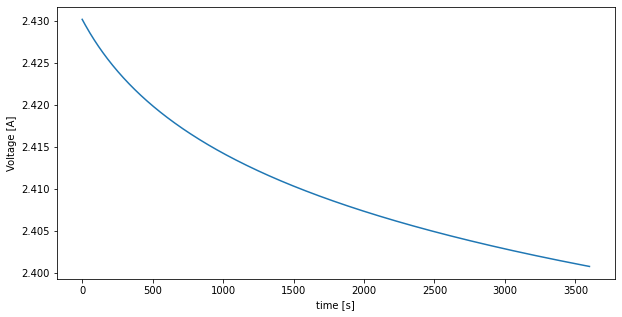

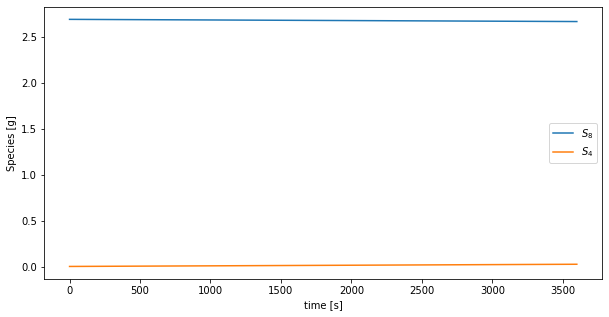

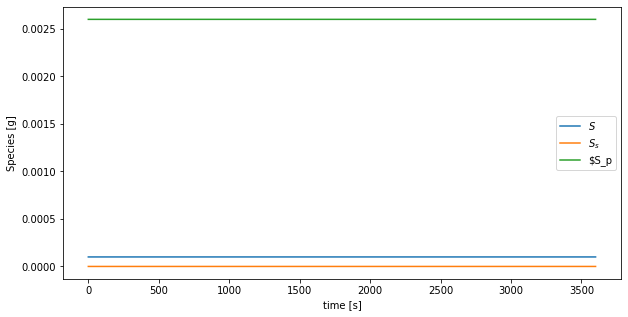

In [128]:
# plotting

plt.figure(1)
plt.plot(t_sol, V_sol)
plt.xlabel('time [s]')
plt.ylabel('Voltage [A]')

plt.figure(3)
plt.plot(t_sol, S8_sol)
plt.plot(t_sol, S4_sol)
plt.xlabel('time [s]')
plt.ylabel('Species [g]')
plt.legend(['$S_8$','$S_4$'])

plt.figure(4)
plt.plot(t_sol, S_sol)
plt.plot(t_sol,Ss_sol)
plt.plot(t_sol,Sp_sol)
plt.xlabel('time [s]')
plt.ylabel('Species [g]')
plt.legend(['$S$','$S_s$','$S_p$']);



# Ramping up proceedure 

In [161]:
# ramp up over one second
dt = 1e-2
n = int(1/dt)
t_ramp = np.linspace(0,1,n)

# create space of currents from zero to initial
I_initial = 1 # desired initial condition
I_ramp = np.linspace(0,I_initial,n)

ramp up process is as follows:

* initialize system with zero current initial conditions
* solve one step with pybamm (using t+1 current)
* set solution to the previous step as the new initial condition
* repeat until solution with I=I_initial is found

In [139]:
t_temp = np.linspace(0,dt,2)
t_temp

array([0.e+00, 1.e-06])

In [162]:
# initialize parameters
I = I_ramp[0]
params = [R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,
          rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,
          il0,ar,m_s,I,i_h_term_coef,i_coef,
          i_h_coef,i_l_coef,E_H_coef,f_h,f_l]


# use previous zero current initial conditions
model.initial_conditions = {S8 : pybamm.Scalar(S8_initial),
                            S4 : pybamm.Scalar(S4_initial), 
                            S2 : pybamm.Scalar(S2_initial),
                            S : pybamm.Scalar(S_initial),
                            Sp : pybamm.Scalar(Sp_initial),
                            Ss : pybamm.Scalar(Ss_initial), 
                            V : pybamm.Scalar(V_initial)}

# create time space for the single step 
t_temp = np.linspace(0,dt,3)

# store data
S8_data = [S8_initial]
S4_data = [S4_initial]
S2_data = [S2_initial]
S_data  = [S_initial]
Ss_data = [Ss_initial]
Sp_data = [Sp_initial]
V_data  = [V_initial]

for i in range(0,n):
    # define the solver
    model = pybamm.BaseModel()
    
    S8 = pybamm.Variable("S8")
    S4 = pybamm.Variable("S4")
    S2 = pybamm.Variable("S2")
    S  = pybamm.Variable("S")
    Sp = pybamm.Variable("Sp")
    Ss = pybamm.Variable("Ss")
    V  = pybamm.Variable("V")
    
    model.variables = {"S8" : S8,
                       "S4" : S4,
                       "S2" : S2,
                       "S" : S,
                       "Sp" : Sp,
                       "Ss" : Ss,
                       "V" : V}
    
    model.rhs = {S8 : dS8dt, 
                 S4 : dS4dt, 
                 S2 : dS2dt, 
                 S  : dSdt, 
                 Sp : dSpdt, 
                 Ss : dSsdt }
    
    model.algebraic = {V : algebraic_condition}
    
    # update current 
    I = I_ramp[i]
    params = [R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,
              rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,
              il0,ar,m_s,I,i_h_term_coef,i_coef,
              i_h_coef,i_l_coef,E_H_coef,f_h,f_l]
    
    # update new initial condition 
    model.initial_conditions = {S8 : pybamm.Scalar(S8_data[-1]),
                                S4 : pybamm.Scalar(S4_data[-1]), 
                                S2 : pybamm.Scalar(S2_data[-1]),
                                S  : pybamm.Scalar(S_data[-1]),
                                Sp : pybamm.Scalar(Sp_data[-1]),
                                Ss : pybamm.Scalar(Ss_data[-1]), 
                                V  : pybamm.Scalar(V_data[-1])}
    
    disc = pybamm.Discretisation()  # use the default discretisation
    disc.process_model(model)
    solution = dae_solver.solve(model, t_temp)
    
    # retrieve solution
    S8_sol = solution["S8"].data
    S4_sol = solution["S4"].data
    S2_sol = solution["S2"].data
    S_sol  = solution["S"].data
    Sp_sol = solution["Sp"].data
    Ss_sol = solution["Ss"].data
    V_sol  = solution["V"].data
    
    # store data
    S8_data.append(S8_sol[-1])
    S4_data.append(S4_sol[-1])
    S2_data.append(S2_sol[-1])
    S_data.append(S_sol[-1])
    Ss_data.append(Ss_sol[-1])
    Sp_data.append(Sp_sol[-1])
    V_data.append(V_sol[-1])

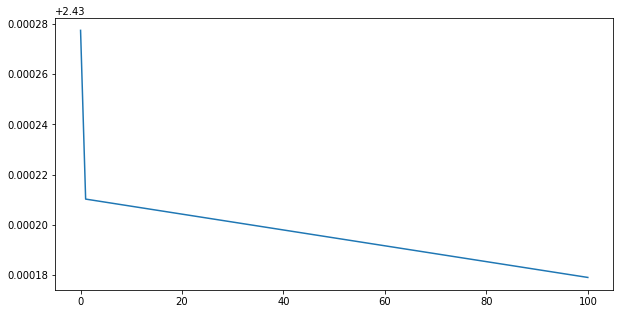

In [164]:
plt.plot(V_data)

In [195]:
model = pybamm.BaseModel()
    
S8 = pybamm.Variable("S8")
S4 = pybamm.Variable("S4")
S2 = pybamm.Variable("S2")
S  = pybamm.Variable("S")
Sp = pybamm.Variable("Sp")
Ss = pybamm.Variable("Ss")
V  = pybamm.Variable("V")

model.variables = {"S8" : S8,
                   "S4" : S4,
                   "S2" : S2,
                   "S" : S,
                   "Sp" : Sp,
                   "Ss" : Ss,
                   "V" : V}

model.rhs = {S8 : dS8dt, 
             S4 : dS4dt, 
             S2 : dS2dt, 
             S  : dSdt, 
             Sp : dSpdt, 
             Ss : dSsdt }

model.algebraic = {V : algebraic_condition}

# update current 
I = I_initial
params = [R,T,F,v,EH0,EL0,k_p,k_s,f_s,S_star,
          rho_s,Ms,ne,ns,ns2,ns4,ns8,n4,ih0,
          il0,ar,m_s,I,i_h_term_coef,i_coef,
          i_h_coef,i_l_coef,E_H_coef,f_h,f_l]

# update new initial condition 
model.initial_conditions = {S8 : pybamm.Scalar(S8_data[-1]),
                            S4 : pybamm.Scalar(S4_data[-1]), 
                            S2 : pybamm.Scalar(S2_data[-1]),
                            S  : pybamm.Scalar(S_data[-1]),
                            Sp : pybamm.Scalar(Sp_data[-1]),
                            Ss : pybamm.Scalar(Ss_data[-1]), 
                            V  : pybamm.Scalar(V_data[-1])}


dae_solver = pybamm.CasadiSolver(mode="safe",atol=1e-6)
seconds = 50000
dt = 1e-3
t = np.linspace(0, seconds, int(seconds/dt))
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model)
solution = dae_solver.solve(model, t)

CasADi - 2020-05-05 20:38:49 WARNING("F:daeF failed: NaN detected for output ode, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 20:38:49 WARNING("F:daeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 20:38:49 WARNING("F:daeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 20:38:49 WARNING("F:daeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 20:38:49 WARNING("F:daeF failed: NaN detected for output ode, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 20:38:49 WARNING("F:jacF failed: NaN detected for output o0, at nonzero index 1 (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
CasADi - 2020-05-

In [ ]:
# retrieve data
t_sol  = solution.t
S8_sol = solution["S8"].data
S4_sol = solution["S4"].data
S2_sol = solution["S2"].data
S_sol  = solution["S"].data
Sp_sol = solution["Sp"].data
Ss_sol = solution["Ss"].data
V_sol  = solution["V"].data

data = t_sol, S8_sol, S4_sol, S2_sol, S_sol, Sp_sol, Ss_sol, V_sol

In [ ]:
# plotting

plt.figure(1)
plt.plot(t_sol, V_sol)
plt.xlabel('time [s]')
plt.ylabel('Voltage [A]')

plt.figure(3)
plt.plot(t_sol, S8_sol)
plt.plot(t_sol, S4_sol)
plt.xlabel('time [s]')
plt.ylabel('Species [g]')
plt.legend(['$S_8$','$S_4$'])

plt.figure(4)
plt.plot(t_sol, S_sol)
plt.plot(t_sol,Ss_sol)
plt.plot(t_sol,Sp_sol)
plt.xlabel('time [s]')
plt.ylabel('Species [g]')
plt.legend(['$S$','$S_s$','$S_p$']);

